# INITIALIZATION 

In [0]:
from pyspark import SparkContext
import json
import time

# Path to the JSON file (in DBFS)
json_file_path = "/FileStore/shared_uploads/datasets/100Kprofiles.json"

# path of ground_truth
ground_truth_path = "/FileStore/shared_uploads/datasets/100KIdDuplicates.json" 

#LOAD THE JSON FILE

The code json_rdd = sc.textFile(json_file_path) reads the contents of the file as plain text (located at the json_file_path) and creates an RDD where each element corresponds to a line in the text file. This is often the first step in processing data with Spark, as it allows you to work with large datasets that are distributed across a cluster.

SO IT'S ALREADY PARALLELIZE! 
reads the data in parallel from multiple workers in the cluster and distributes it across the RDD.
sc.parallelize() it's used when we read from a list


In [0]:
# starting measuring time for data preprocessing
starting_preprocessing = time.time()


def read_json_file(json_file_path):
    # Start a Spark Context
    sc = SparkContext.getOrCreate()

    # Read the JSON file as plain text
    json_rdd = sc.textFile(json_file_path)

    return json_rdd

# Call the function to read the JSON file
json_rdd = read_json_file(json_file_path)

# Print the first 5 lines to check
for record in json_rdd.take(5):
    print(f"{record} \n")

{"date_of_birth":"19190809","address_1":"pudney street","address_2":"arlington","postcode":"3764","soc_sec_id":"3423802","given_name":"luke","realProfileID":"0","surname":"chandler","street_number":"376","suburb":"hemmant","phone_number":"02 24496575","state":"qld","age":"35"} 

{"realProfileID":"1","date_of_birth":"19300528","surname":"hawes","address_2":"northern tablelands tennis academy","postcode":"2168","soc_sec_id":"2180735","street_number":"8","suburb":"keilor east","phone_number":"04 87308830","state":"qld","given_name":"millane","age":"36"} 

{"realProfileID":"2","surname":"novadk","address_1":"rfreet rankin","date_of_birth":"19300112","soc_sec_id":"4272019","street_number":"1","postcode":"3218","suburb":"beulah park","phone_number":"03 39054375","state":"qld","given_name":"jatmike","age":"26"} 

{"address_1":"davenport street","date_of_birth":"19950727","address_2":"vinery","postcode":"3030","soc_sec_id":"5381275","given_name":"madeleine","realProfileID":"3","surname":"redmo

#TOKENIZATION PHASE

This approach is effective for creating a rich representation of text data, capturing local patterns within strings. The use of trigrams is particularly useful for fuzzy matching, as it allows for the detection of similarities even in the presence of minor differences or typographical errors.

For example, a name like "Smith" would be broken down into trigrams like ['smi', 'mit', 'ith']. This set of trigrams can then be compared to other sets to find similarities, even with slightly misspelled versions of the name.

The tokens in an RDD for each record are tuple of (recordID, [token1, token2, ...])

In [0]:
def generate_trigrams(text):
    """
    Generates trigrams (3-grams) for a given text, treating each word separately.

    Parameters:
    - text: A string from which trigrams will be generated.
    
    Returns:
    - A set of trigrams for the text.
    """
    text = text.lower().replace(" ", "")  # Remove white spaces from the text

    # Generate trigrams
    trigrams = set(text[i:i+3] for i in range(len(text) - 2))
       
    return trigrams


def tokenize_line_with_trigrams(line):
    try:
        # Convert the JSON string to a dictionary
        record = json.loads(line)
        record_id = record["realProfileID"]

        # Tokenization using trigrams..  extracting the rpID and generate trigrams from other
        tokens = set()
        for key, value in record.items():
            if key != "realProfileID" and value:
                tokens.update(generate_trigrams(str(value)))  # Convert value to string to handle non-text fields

        return (record_id, tokens)
    except json.JSONDecodeError:
        return None

# Applying the tokenization with trigrams to RDD
tokenized_rdd = json_rdd.map(tokenize_line_with_trigrams).filter(lambda x: x is not None)

# Cache the results
tokenized_rdd = tokenized_rdd.cache()

# Print the first 5 sets of tokens to check
for i, record in tokenized_rdd.take(5):
    print([i,record])
    print(f" numero di token: {len(record)}")


# Map the RDD to lengths
lengths_rdd = tokenized_rdd.map(lambda x: len(x[1]))

# Calculate the average length of the tokens in the records
total_length = lengths_rdd.reduce(lambda a, b: a + b)
average_length = total_length / lengths_rdd.count()

print(f"\nAverage length of tokens: {average_length}")

['0', {'190', 'ton', '376', 'cha', '080', 'ngt', 'ney', '919', 'qld', '575', 'rli', 'han', 'ant', 'eet', 'yst', '496', 'lin', '965', 'udn', 'uke', '908', 'and', 'luk', '342', 'dne', '238', '224', 'hem', 'pud', 'dle', 'emm', 'ree', '380', 'ndl', 'tre', 'man', 'arl', 'ing', 'eys', '764', 'ler', '244', 'mma', '022', '809', '449', '657', '423', '802', '191', 'gto', 'str'}]
 numero di token: 52
['1', {'216', 'nis', 'ill', 'ane', 'ort', 'ore', '883', '300', '088', 'the', 'abl', 'ade', 'isa', '735', 'rnt', 'qld', 'rea', '073', 'ast', 'kei', 'eil', '005', '930', '730', 'ten', '048', 'dem', 'lan', 'cad', '308', '180', '052', 'aca', '830', 'and', 'wes', 'rth', 'sac', 'her', 'ela', 'nor', 'tab', 'mil', '193', 'ste', '168', 'ilo', 'emy', 'nta', 'ern', 'nds', 'ble', '218', '528', 'awe', 'dst', 'lor', '487', 'lla', 'nni', 'eas', '873', 'enn', 'lel', 'haw', '807'}]
 numero di token: 66
['2', {'011', 'adk', 'fre', 'etr', '201', '437', '300', 'tmi', 'nki', 'kin', 'qld', '543', 'par', 'mik', 'atm', '930

#COMPUTE THE FREQUENCY

Remember that if token_freq... is an RDD, you'll need to first use the .collect() method to bring the data to the driver node before doing the above operations. If it's a dictionary resulting from countByValue(), you can directly use the above snippets.

In [0]:
def analyze_token_frequency(rdd, top_k=10):
    """
    Analyze and display the most common and uncommon tokens in an RDD of tokenized records.
    
    Parameters:
    - rdd: Input RDD where each record is of the form (recordID, [token1, token2, ...])
    - top_k: Number of top tokens to display for common and uncommon tokens.
    
    Returns:
    - A variable containing the token frequency dictionary.
    """
    
    # Compute the frequency of each token across all sets
    token_freq_dict = rdd.flatMap(lambda x: x[1]).countByValue()
    
    # Sort the tokens 
    sorted_tokens_common = sorted(token_freq_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_tokens_uncommon = sorted(token_freq_dict.items(), key=lambda x: x[1])
    
    # Display the most common tokens
    print("COMMON TOKENS: \n")
    for token, freq in sorted_tokens_common[:top_k]:
        print(f"Token: {token}, Frequency: {freq}")
    
    # Display the most uncommon tokens
    print("\nUNCOMMON TOKENS: \n")
    for token, freq in sorted_tokens_uncommon[:top_k]:
        print(f"Token: {token}, Frequency: {freq}")
    

    return token_freq_dict

token_freq_dict = analyze_token_frequency(tokenized_rdd)

# Broadcast the dictionary of the frequency to workers
token_freq_broadcast = sc.broadcast(token_freq_dict)

COMMON TOKENS: 

Token: ree, Frequency: 41931
Token: eet, Frequency: 39275
Token: tre, Frequency: 38109
Token: str, Frequency: 35167
Token: nsw, Frequency: 27126
Token: vic, Frequency: 20457
Token: ent, Frequency: 20069
Token: lac, Frequency: 18548
Token: cen, Frequency: 17807
Token: ace, Frequency: 17499

UNCOMMON TOKENS: 

Token: 17l, Frequency: 1
Token: 7l3, Frequency: 1
Token: sfg, Frequency: 1
Token: kgw, Frequency: 1
Token: mwg, Frequency: 1
Token: vqx, Frequency: 1
Token: jwm, Frequency: 1
Token: hpq, Frequency: 1
Token: 2u2, Frequency: 1
Token: 12u, Frequency: 1


#SORT TOKENS IN EACH RECORDS BY FREQUENCY

Now we have the (token, frequency) in each worker and the (RID, {tokens}) RDD

The sort_tokens_by_frequency function aims to reorder the tokens in each record of an RDD based on their global frequency,
which was previously computed and broadcasted. 


Tokens are sorted based on their frequency in ascending order, meaning the rarest tokens (lowest frequency) appear first, followed by more common tokens. 
This is indicated by sorted(tokens, key=lambda token: broadcast_freq.value.get(token, 0))... good before to apply the Prefix filter


For each record in (RID, {tokens}) RDD:

-Fetch its tokens.

-Sort these tokens using the broadcasted frequencies.

-Return the sorted tokens along with the original RID.

IT'S DONE LOCALLY ON EACH WORKERS

In [0]:
def sort_tokens_by_frequency(rdd, broadcast_freq):
    """
    Sort the tokens in each record by their global frequency.
    
    Parameters:
    - rdd: Input RDD where each record is of the form (recordID, [token1, token2, ...])
    - broadcast_freq: A Spark broadcast variable containing the global frequency of tokens.
    
    Returns:
    - An RDD with each record having tokens sorted by their frequency.
    """
    def sort_tokens_by_freq(record):
        # unpack the record
        record_id, tokens = record 
        # Use the broadcast variable for sorting from rare to common
        sorted_tokens = sorted(tokens, key=lambda token: broadcast_freq.value.get(token, 0))  # if no frequencies are founded = 0
        # Return the RID with the Sorted Tokens
        return (record_id, sorted_tokens)

    # Apply the function MAP on each RDD record
    sorted_rdd = rdd.map(sort_tokens_by_freq)
    return sorted_rdd

sorted_tokens_rdd = sort_tokens_by_frequency(tokenized_rdd, token_freq_broadcast)

# Print a sample of ordered records
for record in sorted_tokens_rdd.take(2):
    print(record)

# stopping measuring the time for data preprocessing
time_of_preprocessing = time.time() - starting_preprocessing
print(f"\nTime of preprocessing execution: {time_of_preprocessing}")

('0', ['pud', 'udn', 'dne', 'hem', 'uke', 'luk', 'mma', 'ndl', 'emm', '657', '575', '449', '496', '764', '376', 'rli', 'ney', '238', '342', '423', 'eys', 'dle', '965', '224', '244', '919', 'gto', 'ngt', '809', '802', '380', 'ler', '908', 'ant', 'yst', 'arl', 'han', '080', 'lin', 'cha', '022', 'man', 'and', '191', '190', 'ing', 'ton', 'qld', 'str', 'tre', 'eet', 'ree'])
('1', ['rnt', 'emy', 'tab', 'sac', 'abl', 'dem', 'aca', 'awe', 'kei', 'cad', 'lel', 'ilo', 'eil', 'nis', 'rea', 'ten', 'nta', '883', 'nni', '735', '873', 'haw', 'ble', '528', '168', 'lor', 'ela', 'nds', 'ade', '180', 'isa', 'dst', '218', '487', 'ern', 'enn', '005', 'wes', '807', '830', 'ane', '730', '300', 'mil', 'eas', '930', '308', '216', '048', '088', '052', 'ore', '073', 'ste', 'her', 'nor', 'the', 'rth', 'ast', 'ort', 'lan', 'and', 'lla', '193', 'ill', 'qld'])

Time of preprocessing execution: 10.539979219436646


#PREFIX FILTERING



The primary goal of the prefix filter is to significantly reduce the number of candidate pairs that the more computationally intensive subsequent filters (like positional filtering) have to deal with.
The chosen threshold should balance computational efficiency with the risk of missing similar pairs.

Given two documents, they can reach requested overlap similarity if they shares at least one token in theirfirst 𝑑𝑜𝑐𝐿𝑒𝑛−t+1 tokens

Generate Key-Value Pairs for Prefix Tokens:
 
For each record, we will emit key-value pairs for every token in its prefix (doclen - t + 1), where the key is the token and the value is the record's RID. Generate pairs of the form (token, record_id)

The function generate pairs (tokens[i], record_id) for each token in the prefix.

For this record:(1, ['apple', 'banana', 'cherry']) and prefix length 2, the Mapper will emit:
('apple', 1)
('banana', 1)

Calculating Prefix Length: The length of the prefix for each record is calculated based on the total number of tokens n and the threshold t. 
The formula prefix_length = n - t + 1 determines how many tokens to consider for generating pairs.

prefix_lengh = docLen|A| - t + 1 (in our datasets the lenght of A_records it's about 50 tokens)

If you're getting too many candidate pairs (which might result in longer computation times in subsequent filtering stages), you can adjust the threshold to be stricter (decrease the prefix length). If you're filtering out too much and potentially missing similar pairs, increase the prefix length.

Higher t: Select this for stricter similarity requirements, generating fewer more likely candidate pairs -> increase precision (fewer false positives) but decrease recall (missed true positives).

Lower t: Use this for broader similarity requirements, generating more candidate pairs, including those with less overlap ->  increase recall but decrease precision.



The generate_prefix_pairs_from_rdd function now dynamically calculates the prefix length for each record using the formula

prefix_length = n - int(threshold_prefix * n) + 1, 

Prefix Length=Tokens_of_record − ⌈threshold × Tokens_of_record⌉ + 1

This allow to adjusting the prefix length based on the size of the token sets and the desired similarity threshold, this ensures that the number of tokens considered for each record is proportional to its size and the desired similarity level that allows to fine-tune the filtering process based on the characteristics of dataset and the desired level of similarity.

In [0]:
# starting measure of prefix filter execution time
starting_prefix_filtering = time.time()

# Define the similarity threshold
threshold_prefix = 0.8  

# Updated MAPPER to dynamically calculate prefix length
def generate_prefix_pairs_from_rdd(rdd, threshold_prefix):
    """
    Generates prefix pairs for each record in the RDD dynamically based on threshold.
    
    Parameters:
    - rdd: Input RDD where each record is of the form (recordID, [token1, token2, ...])
    - jaccard_threshold: The Jaccard similarity threshold.
    
    Returns:
    - An RDD with prefix pairs.
    """
    def generate_prefix_pairs(record):
        record_id, tokens = record
        # contains the number of tokens of each record
        n = len(tokens)
        # Dynamic calculation of prefix length
        prefix_length = n - int(threshold_prefix * n) + 1 #prefix_lengh = docLen|A| - t + 1 
        
        if prefix_length <= 0:
            return []
        
        for i in range(prefix_length):
            yield (tokens[i], record_id)

    prefix_rdd = rdd.flatMap(generate_prefix_pairs)
    return prefix_rdd

prefix_rdd = generate_prefix_pairs_from_rdd(sorted_tokens_rdd, threshold_prefix)

# For debugging or verification:
for pair in prefix_rdd.take(20):
    print(pair)

('pud', '0')
('udn', '0')
('dne', '0')
('hem', '0')
('uke', '0')
('luk', '0')
('mma', '0')
('ndl', '0')
('emm', '0')
('657', '0')
('575', '0')
('449', '0')
('rnt', '1')
('emy', '1')
('tab', '1')
('sac', '1')
('abl', '1')
('dem', '1')
('aca', '1')
('awe', '1')



Shuffle: before the reducer starts, there's a shuffle phase. All emitted key-value pairs are shuffled across the network so that all pairs with the same key (in this case with the same token) are grouped together and end up on the same machine.

This requires moving data across different nodes in the cluster, which can be network-intensive, especially for large datasets.


Grouping(reducing): the reducer groups these key-value pairs by their keys. This means all the RIDs that have the same token in their prefix are collected together.

After the shuffle, for each unique token, you get an iterable of record IDs (rids) that contain this token. This operation effectively groups all record IDs by common tokens.


After Shuffle:
('apple', 1)
('apple', 3)
('banana', 1)
('banana', 2)
('cherry', 2)

After Grouping:
('apple', [1, 3])
('banana', [1, 2])
('cherry', [2])


In [0]:
#SHUFFLING AND REDUCING
grouped_rdd = prefix_rdd.groupByKey()

# print a sample of 1 tokens and the corresponding list of record IDs (rids) from grouped_rdd.
for token, rids in grouped_rdd.take(2):
    print("Token:",token,"RIDs: ", list(rids))

Token: udn RIDs:  ['0', '7624', '7735', '8026', '9171', '11091', '15394', '17116', '18078', '21413', '22890', '23314', '25055', '33918', '36351', '37994', '38001', '43931', '45144', '46751', '49421', '52590', '52982', '62550', '63746', '74606', '76267', '81961', '83778', '86442', '87984', '89667', '90012', '90431', '92289', '95228', '95448']
Token: hem RIDs:  ['0', '33', '597', '800', '1029', '1103', '1302', '1365', '2156', '2471', '4499', '5116', '5689', '5932', '5949', '6005', '6071', '6203', '6703', '6946', '7625', '7722', '8281', '9083', '9356', '9519', '10149', '10171', '10377', '10559', '10883', '11470', '11982', '11989', '12433', '12546', '12560', '12630', '12667', '13188', '13311', '13611', '13616', '14041', '14075', '14255', '14748', '15093', '17035', '17278', '17592', '18627', '19233', '19486', '19895', '19920', '20081', '20321', '20380', '20436', '21336', '21465', '21495', '21556', '22557', '23019', '23483', '23623', '24071', '24168', '24376', '24985', '25602', '25861', '261

Essentially, it's an inverted index

##GENERATING CANDIDATE PAIRS

For each token, take the list of RIDs and form candidate pairs. This essentially means for a list of RIDs [a, b, c], you will form pairs [(a, b), (a, c), (b, c)].

The idea behind this step is that if two records share a token in their prefix, they might be similar. Hence, they are considered as candidate pairs and will be subjected to subsequent filters to restrict down true similarities.

The function generate_candidate_pairs: 

Generate all 2-combinations of the list of RIDs. For each token returns all possible pairs of RIDs that have this token in their prefix.

input (kv) is a key-value pair, where the key is a token and the value (kv[1]) is a list of RIDs associated with that token.

flatMap "flattens" the results, producing an RDD of the individual elements instead an RDD of list

In [0]:
from itertools import combinations

def generate_candidate_pairs(grouped_rdd):
    """
    Generates candidate pairs of RIDs that share a common token in their prefix.

    Parameters:
    - grouped_rdd: Input RDD where each record is a key-value pair. The key is a token and the value is a list of RIDs associated with that token.

    Returns:
    - An RDD of candidate pairs, where each element is a tuple representing a pair of RIDs that share at least one common token in their prefix.
    """
    candidate_pairs_after_prefix_rdd = grouped_rdd.flatMap(lambda kv: combinations(kv[1], 2))

    return candidate_pairs_after_prefix_rdd


candidate_pairs_after_prefix_rdd = generate_candidate_pairs(grouped_rdd)

candidate_pairs_after_prefix_rdd_count = candidate_pairs_after_prefix_rdd.count()

print("Candidate Pairs after Prefix Filter:", candidate_pairs_after_prefix_rdd_count, "\n")


# For debugging:
sample_candidate_pairs = candidate_pairs_after_prefix_rdd.take(10)
for pair in sample_candidate_pairs:
    print(list(pair))

#This will give you pairs of RIDs that share a common token in their prefix.

# stopping measure of lenght filter execution time
time_of_prefix_filtering = time.time() - starting_prefix_filtering
print(f"\nTime of execution of prefix filtering {time_of_prefix_filtering}")

Candidate Pairs after Prefix Filter: 173805553 

['0', '7624']
['0', '7735']
['0', '8026']
['0', '9171']
['0', '11091']
['0', '15394']
['0', '17116']
['0', '18078']
['0', '21413']
['0', '22890']

Time of execution of prefix filtering 19.592532634735107


#LENGHT FILTER:

###Create an RDD of records with RID and length of the token set
we'll create an RDD of records that includes both the RID and the length of the token set:


The lambda function "lambda kv": (kv[0], len(kv[1])) takes each key-value pair kv (where kv[0] is the RID and kv[1] is the token set) and transforms it into a new pair (RID, number_of_tokens)

The result is a new RDD, record_lengths_rdd, where each element is a tuple consisting of a record ID and the corresponding number of tokens in that record.


Purpose of Length Information: The length of the token set for each record is useful in many scenarios, especially when we need to compute similarity measures or apply filters based on token counts. For instance, in similarity join tasks, we might want to compare only those records that have a similar number of tokens.

Other Steps: typically, this length information might be used in subsequent steps to apply length-based filters, such as discarding pairs of records where the difference in the number of tokens exceeds a certain threshold. This can significantly reduce the number of comparisons in similarity join algorithms.

In [0]:
# starting measure of lenght filter execution time
starting_lenght_filtering = time.time()

# compute the lenght of the token set for each record - len(kv[1]) -> number of tokens in the set
record_lengths_rdd = tokenized_rdd.map(lambda kv: (kv[0], len(kv[1])))

#MAPPER
for record in record_lengths_rdd.take(5):
    print(record)

('0', 52)
('1', 66)
('2', 49)
('3', 60)
('4', 58)


###Join the RDD with candidate pairs to get lengths for both RIDs:

In this step, we're joining the candidate pairs with their corresponding token lengths. This is an important step in filtering candidate pairs based on their token lengths.

We start with candidate_pairs_after_prefix_rdd, which is a result from the previous step containing potential similar pairs (RID1, RID2). This line is joining this RDD with the record_lengths_rdd to associate the length of the token set with each RID. The join operation combines records with the same key (RID) from both RDDs.
The result, pair_lengths_rdd, will have elements in the form: {RID1, (RID2, length_of_RID1)}.

After the join, we restructure the RDD to facilitate another join to get lengths for both RIDs in the pair, by swapping the keys and values. 

The key becomes RID2, and the value becomes a tuple (RID1, length_of_RID1).

After this mapping, we join the refactored RDD with record_lengths_rdd again.

The resulting RDD, pair_lengths_rdd_refactored, will have elements in the form: {RID2, ((RID1, length_of_RID1), length_of_RID2)}.

Why do we do this?

By knowing the lengths of the token sets for each pair of RIDs, we can apply lenght filter (only consider pairs where the length difference is within a certain threshold) to reduce the number of pairs to those most likely to be similar.

In [0]:
# join on RID

# MAPPER 
# REDUCER (join): brings together pairs from RDDs that have the same key. Combines records with the same key (RID) from both RDDs.
pair_lengths_rdd = candidate_pairs_after_prefix_rdd.join(record_lengths_rdd) # 
print("pair_lengths_rdd: {RID1, (RID2, lenght_of_RID1)} ", pair_lengths_rdd.take(1))

pair_lenghts_rdd_refactored = pair_lengths_rdd.map(lambda kv: (kv[1][0],(kv[0], kv[1][1]))).join(record_lengths_rdd)

print("pair_lengths_rdd: {RID2, (RID1, lenght_of_RID1), lenght_of_RID2} ", pair_lenghts_rdd_refactored.take(1))

###Use formula to filter pairs based on length criteria:

This is the core step of the length filter: if the lengths of the two sets in a pair are too different, they can't possibly have a high similarity. By filtering these out, we're reducing the number of pairs we need to check in the next steps... filters out pairs that are unlikely to be similar based on the length of their token sets and a specified similarity threshold.


Now, we'll use the derived formula to filter pairs based on the length criteria: by applying the formula derived from the Jaccard similarity principle, we filter out pairs where the lengths of their sets are too different to possibly meet the threshold.

For the length filter, we're interested in the numerator: 
∣A∩B∣, the size of the intersection. The goal is to find a lower bound for this intersection given a certain threshold t.
To achieve the similarity t, the intersection ∣A∩B∣ should be: ∣A∩B∣≥t×min(∣A∣,∣B∣)
This gives the minimum required intersection size for a given similarity threshold t.

Threshold Selection: the choice of the similarity threshold is important: a high threshold might lead to missing some similar pairs, while a low threshold could include more FP.

Performance Impact: the filter operation is generally efficient as it processes each record independently and doesn't involve shuffling data, but the efficiency also depends on how many records pass the filter.

Example:
    
Pair: ('7078', (('4481', 63), 57))
Lengths: RID1 (4481) = 63, RID2 (7078) = 57

Applying the Length Filter:

Min Length = min(63, 57) = 57

Max Length = max(63, 57) = 63

Max Possible Overlap = Min Length = 57

Min Required Overlap = Threshold × Min Length = 0.7 × 57 ≈ 40

Check for Filtering:

Calculation: (Min Length - Max Length + Max Possible Overlap) = (57 - 63 + 57) = 51
Since 51 is greater than the Min Required Overlap (40), this pair passes the filter.

THRESHOLD CONSIDERATION:

Strict Matching: If the goal is to identify records that are very similar or nearly duplicates, a higher threshold (e.g., 0.8-0.9) ensures only very similar records are considered.

Broad Matching: For exploratory analysis or when broader similarities are relevant, a lower threshold (e.g., 0.5-0.7) might be more suitable.

A higher threshold generally results in fewer comparisons and better performance but might miss some relevant matches.

A lower threshold increases the computational load but might capture more potential similarities.

### METHOD-1 [Bayardo et al, WWW 07 ] - not very effective in our case

def filter_pairs_by_length(pair_rdd, alpha):
    """
    Filters the RDD pairs based on the given length criteria derived from the overlapping threshold alpha.

    Parameters:
    - pair_rdd: RDD in the format {(RID1, RID2), (length_of_RID1, length_of_RID2)}.
    - alpha: The minimum number of overlapping tokens required for a pair to be considered similar.

    Returns:
    - An RDD with pairs filtered by the given criteria.
    """

    def length_filter(value):
        length1, length2 = value[1]
        # The pair is pruned if the smaller document's length is less than alpha
        return min(length1, length2) >= alpha

    return pair_rdd.filter(lambda kv: length_filter(kv))

# Assuming `pair_lengths_rdd` is an RDD with pairs and their lengths
alpha = 10
filtered_pairs_after_lenght_rdd = filter_pairs_by_length(pair_lengths_rdd, alpha)

# Collecting a small sample for demonstration purposes
for record in filtered_pairs_after_lenght_rdd.take(10):
    print(record)


### ALTERNATIVE METHOD WITH JACCARD-LIKE'S THRESHOLD 

In [0]:
# MAPPER

# parametrisations lenght_filter
threshold_lenght = 0.70

def filter_pairs_by_length(pair_lengths_rdd_refactored, threshold_lenght):
    """
    Filters the RDD pairs based on the given length criteria derived from the similarity threshold.

    Parameters:
    - pair_lengths_rdd_refactored: RDD in the format {RID2, (RID1, length_of_RID1, length_of_RID2)}.
    - threshold: Desired similarity threshold.

    Returns:
    - An RDD with pairs filtered by the given criteria.
    """

    def length_filter(value):
        # take the tuple that contains the lenghts of the 2RIDs
        rid1_length = value[0][1]
        rid2_length = value[1]
        min_length = min(rid1_length, rid2_length)
        max_length = max(rid1_length, rid2_length)

        # Calculate the maximum possible overlap
        max_overlap = min_length

        # Derive the minimum required overlap - the min. number of tokens that must overlap for the pair to be considered similar.
        min_required_overlap = threshold_lenght * min_length

        # Check the minimum required overlap against the maximum possible overlap
        return (min_length - max_length + max_overlap) >= min_required_overlap

    return pair_lengths_rdd_refactored.filter(lambda kv: length_filter(kv[1]))


filtered_pairs_after_lenght_rdd = filter_pairs_by_length(pair_lenghts_rdd_refactored, threshold_lenght)

# debugging:
for record in filtered_pairs_after_lenght_rdd.take(10):
    print(record)

('41903', (('16412', 54), 53))
('41903', (('13977', 50), 53))
('41903', (('12651', 57), 53))
('41903', (('28943', 54), 53))
('41903', (('21944', 51), 53))
('41903', (('21944', 51), 53))
('41903', (('2797', 59), 53))
('41903', (('19933', 66), 53))
('41903', (('26659', 49), 53))
('41903', (('26659', 49), 53))


###Keep only the RIDs:

Finally, keep only the RIDs, discarding the lengths:

Now that we've filtered the pairs based on length, we want to keep just the RIDs for further processing. This line maps over the filtered_pairs_after_lenght_rdd and extracts just the RIDs, discarding the lengths. 
FOR SIMPLIFY DATA STRUCTURE

After the length filter, we will have an RDD structure somewhat like:

{RID2, ((RID1, length_of_RID1), length_of_RID2)}
Now, you just need the RID pairs (RID1, RID2), so we can map the structure to get only the pairs of RIDs.

This should get an RDD of the form: (RID1, RID2)

In [0]:
#MAPPER
pairs_after_lenght_rdd = filtered_pairs_after_lenght_rdd.map(lambda kv: (kv[1][0][0], kv[0]))

for record in pairs_after_lenght_rdd.take(5):
    print(record)

pairs_after_lenght_rdd_count = pairs_after_lenght_rdd.count()

print("\n Candidate Pairs after Length Filter:", pairs_after_lenght_rdd_count, "\n")
print(" Candidate Pairs filtered out by Lenght Filter:", candidate_pairs_after_prefix_rdd_count - pairs_after_lenght_rdd_count, "\n")

# stopping measuring the time of lenght filter
time_of_lenght_filtering = time.time() - starting_lenght_filtering
print(f"Time of execution of lenght filtering {time_of_lenght_filtering}")

('16412', '41903')
('13977', '41903')
('12651', '41903')
('28943', '41903')
('21944', '41903')

 Candidate Pairs after Length Filter: 131303333 

 Candidate Pairs filtered out by Lenght Filter: 15738605 

Time of execution of lenght filtering 2447.7112233638763


After this step, final_pairs_rdd will contain candidate pairs that have passed both the prefix and length filters. These pairs have a higher likelihood of being true positives (i.e., genuinely similar pairs). The subsequent positional filter will further refine this set.

#POSITIONAL FILTER


Goal: Further refine our candidate pairs to those which are potentially similar by looking at the actual positions of tokens in each record.

Why?
Even after length and prefix filtering, we might have pairs of records that are not truly similar. Positional filtering checks if the common tokens between two records appear at nearly the same positions. If they do, it's likely that the records are similar. This step is particularly useful to eliminate false positives introduced by common tokens that appear at widely different positions in two records.

##1.Token Positioning

For each record, mark each token with its position.
Associate each token with its position


This function takes a set of tokens and returns a list of tuples, each consisting of a token and its corresponding index (position) in the set.

[ ('record_id1', [('token1', 0), ('token2', 1), ...]),
 ('record_id2', [('tokenA', 0), ('tokenB', 1), ...]),
 ...
]

original:
    'record_id1', ['molly', '41', '6050']
transformed:
        ('record_id1', [('molly', 0), ('41', 1), ('6050', 2)])

For the record '0':
[    ('molly', 0),     ('41', 1),     ('6050', 2),     ...    ('batlow', 10)]


The token 'molly' is in position 0, the token '41' is in position 1, and so on.

This positional information will be crucial when applying the positional filtering. Positional filtering, in essence, ensures that tokens from similar records (candidate pairs) not only match but also are proximate in terms of their positions.

In [0]:
# starting measuring the time for position filtering
starting_position_filtering = time.time()

def position_tokens(tokens):
    return [(token, idx) for idx, token in enumerate(tokens)]

# mapValues only processes the values of the key-value pairs in the RDD, leaving the keys (the record IDs) unchanged.
positioned_rdd = tokenized_rdd.mapValues(position_tokens)
positioned_rdd = positioned_rdd.cache()
#positioned_rdd have the same keys (RID) of tokenized_rdd, but the values now are lists of (token, index) pairs instead of sets of tokens.

positioned_rdd.take(5)

Out[29]: [('0',
  [('289', 0),
   ('ent', 1),
   ('tlo', 2),
   ('290', 3),
   ('esc', 4),
   ('atl', 5),
   ('841', 6),
   ('829', 7),
   ('050', 8),
   ('res', 9),
   ('899', 10),
   ('qld', 11),
   ('mol', 12),
   ('hop', 13),
   ('060', 14),
   ('oll', 15),
   ('lly', 16),
   ('ley', 17),
   ('939', 18),
   ('082', 19),
   ('ycr', 20),
   ('609', 21),
   ('bis', 22),
   ('ale', 23),
   ('ish', 24),
   ('467', 25),
   ('low', 26),
   ('eyc', 27),
   ('684', 28),
   ('cen', 29),
   ('193', 30),
   ('dal', 31),
   ('sce', 32),
   ('906', 33),
   ('cre', 34),
   ('028', 35),
   ('bat', 36),
   ('902', 37),
   ('605', 38),
   ('390', 39),
   ('768', 40),
   ('sho', 41),
   ('996', 42),
   ('676', 43)]),
 ('1',
  [('190', 0),
   ('110', 1),
   ('411', 2),
   ('ort', 3),
   ('756', 4),
   ('294', 5),
   ('ucc', 6),
   ('nam', 7),
   ('von', 8),
   ('buc', 9),
   ('amb', 10),
   ('ast', 11),
   ('mbu', 12),
   ('200', 13),
   ('eet', 14),
   ('don', 15),
   ('hkt', 16),
   ('629', 17),
   

##2.Join the distinct_pairs_rdd with the positioned_rdd based on tokens:

Now, by using this positioned RDD (positioned_rdd) we:

-Join candidate pairs based on their tokens and filter based on their positions.

-Further prune candidate pairs based on Jaccard similarity.

To achieve this, we first need to do the join operation on final_pairs_rdd with the positioned_rdd and then perform the positional filtering.

We have the positioned_rdd in the format:
('record_id', [('token1', position1), ('token2', position2), ...])

And the pairs_after_lenght_rdd (from previous prefix filtering) in the format:
('RID1', 'RID2')

The join operation in Spark combines two RDDs based on their keys

Each element in distinct_pairs_rdd is joined with the corresponding element in positioned_rdd based on matching record IDs. This join will result in a new RDD where each element consists of a record ID and a tuple containing the pair of RIDs from final_pairs_rdd and the list of positioned tokens from positioned_rdd.

Output Format
After the join, the RDD first_join should have elements in the format:
('RID1', ('RID2', [('token_rid1_1', position1), ('token_rid_2', position2), ..., ('token_rid1_N', positionN)]))

This format represents the association of each RID pair with the positioned tokens of one of the records in the pair.

Example:
    
Each element of the resulting RDD (first_join) is a tuple with two main components:
    
First Element:

('1059', ...): This is RID1.

Second Element (Nested Tuple):

The first part of the nested tuple, '7078' is example of RID2.
The second part of the nested tuple is a list of positioned tokens from RID1's (1059) token set, like [('och', 0), ('190', 1), ..., ('kwo', 62)].

We get this format of data: ('RID1', ('RID2', [positioned tokens of RID1])).

The key '1059' is RID1, and the value is a tuple containing '7078' as RID2 and the list of positioned tokens associated with RID1 ('1059').


In [0]:
first_join = pairs_after_lenght_rdd.join(positioned_rdd)

first_join.take(1)

Out[30]: [('2392',
  ('3136',
   [('190', 0),
    ('avi', 1),
    ('ent', 2),
    ('tlo', 3),
    ('cyc', 4),
    ('esc', 5),
    ('for', 6),
    ('ore', 7),
    ('000', 8),
    ('075', 9),
    ('300', 10),
    ('591', 11),
    ('dge', 12),
    ('res', 13),
    ('730', 14),
    ('ier', 15),
    ('936', 16),
    ('adi', 17),
    ('odg', 18),
    ('nad', 19),
    ('377', 20),
    ('606', 21),
    ('lod', 22),
    ('007', 23),
    ('ycr', 24),
    ('071', 25),
    ('719', 26),
    ('xav', 27),
    ('517', 28),
    ('171', 29),
    ('eon', 30),
    ('est', 31),
    ('037', 32),
    ('cen', 33),
    ('193', 34),
    ('sce', 35),
    ('755', 36),
    ('773', 37),
    ('vie', 38),
    ('erc', 39),
    ('cre', 40),
    ('559', 41),
    ('907', 42),
    ('rcy', 43),
    ('stl', 44),
    ('ona', 45),
    ('064', 46),
    ('per', 47),
    ('leo', 48)]))]

#### For debugging pourpose - check the correct structure of join - change to pythoncode

for i, record in positioned_rdd.collect():
    if i=='1059':
        print(f"{record} \n")
    if i=='7078':
        print(f"{record} \n")



##3.Reformat the RID and token, then join again:

The lambda function inside map restructures each element of first_join. It changes the format from ('RID1', ('RID2', [('token1', position1), ...])) to ('RID2', ('RID1', [('token1', position1), ...])).

so the final form will be this one: ('RID2', ('RID1', [positioned tokens of RID1])).

In this step, we're performing a second join operation to bring together the positioned token data for both records in each candidate pair.


Then join this transformed RDD with positioned_rdd on RID2.

This join operation combines the positioned tokens of RID1 (already in the transformed RDD) with the positioned tokens of RID2 (from positioned_rdd).

Output Format:

After the join, each element of second_join should have the following format:

('RID2', (('RID1', [('token1_RID1', pos1_RID1), ...]), [('token1_RID2', pos1_RID2), ...])) - ('RID2', (('RID1', [positioned tokens of RID1]), [positioned tokens of RID2]))

This means for each pair of record IDs (RID1 and RID2), we have now the positioned tokens of both RID1 and RID2.

Example:
    
Key: RID2 ('7078')

Value -> tuple consisting of:

1a Part: a tuple (('RID1', [positioned tokens of RID1])) RID1 + list of (tokens,pos)

2nd Part: ([positioned tokens of RID2]), list of positioned tokens associated with RID2

In [0]:
second_join = first_join.map(lambda kv: (kv[1][0], (kv[0], kv[1][1]))).join(positioned_rdd)

second_join.take(1)

Out[31]: [('6653',
  (('2392',
    [('190', 0),
     ('avi', 1),
     ('ent', 2),
     ('tlo', 3),
     ('cyc', 4),
     ('esc', 5),
     ('for', 6),
     ('ore', 7),
     ('000', 8),
     ('075', 9),
     ('300', 10),
     ('591', 11),
     ('dge', 12),
     ('res', 13),
     ('730', 14),
     ('ier', 15),
     ('936', 16),
     ('adi', 17),
     ('odg', 18),
     ('nad', 19),
     ('377', 20),
     ('606', 21),
     ('lod', 22),
     ('007', 23),
     ('ycr', 24),
     ('071', 25),
     ('719', 26),
     ('xav', 27),
     ('517', 28),
     ('171', 29),
     ('eon', 30),
     ('est', 31),
     ('037', 32),
     ('cen', 33),
     ('193', 34),
     ('sce', 35),
     ('755', 36),
     ('773', 37),
     ('vie', 38),
     ('erc', 39),
     ('cre', 40),
     ('559', 41),
     ('907', 42),
     ('rcy', 43),
     ('stl', 44),
     ('ona', 45),
     ('064', 46),
     ('per', 47),
     ('leo', 48)]),
   [('102', 0),
    ('040', 1),
    ('018', 2),
    ('pur', 3),
    ('868', 4),
    ('spu', 5),

#### For debugging pourpose - test to check the correct structure of join - chance to pythoncode

for i, record in positioned_rdd.collect():
    if i=='1059':
        print(f"{record} \n")
    if i=='7078':
        print(f"{record} \n")

Comparing Tokens and Positions:

This step is crucial for positional filtering because it aligns the positioned tokens of both records in each candidate pair.Both lists have tokens and their respective positions in the records. 

Now, we can filter pairs where the token positions in both records are close enough based on a threshold.

##4.Filter out the pairs of records that doesn't satisfy the positional constraint.

Threshold Interpretation

The similarity_threshold represents the robustness of the similarity requirement. A higher threshold requires more evidence of similarity (more matching tokens), making it stricter.

A lower threshold is more lenient, requiring fewer matching tokens to consider two records as similar.

The max_positional_difference accounts for variations in the token positions between the records. It defines how closely the positions must align for a token to be considered common.

Logic of filter:

similarity_threshold is the minimum number of common tokens that two records must have to be considered similar.

max_positional_difference is the maximum distance allowed between the positions of the same token in the two records.

rec1_tokens contains the positioned tokens from the first record (RID1), and rec2_tokens_dict is a dictionary that is used to lookups of the positions of tokens from the second record (RID2).

common_tokens counter is initialized to zero and will keep track of how many token matches have been found between the two records.

possible_common_tokens starts as the minimum length of the two token lists (since that's the maximum possible matches) and decrements as we iterate through the tokens of RID1, because there's one less token to potentially match with.

For each token in rec1_tokens, the function looks up the position of the same token in rec2_positions. If the token exists in both records and the absolute difference in their positions is less than or equal to max_positional_difference, it is counted as a common token (common_tokens + 1)

After each token comparison, the function checks if it's still possible to meet the similarity_threshold.
It does this by adding common_tokens and possible_common_tokens. If their sum is less than similarity_threshold, the function concludes that the records can't be similar and returns False.
This check allows the function to stop early if it's already impossible for the pair to meet the similarity criteria, saving unnecessary computation.

If the loop completes without triggering the early stopping rule, the function checks if the number of common_tokens found meets or exceeds the similarity_threshold.
If it does, the function returns True, indicating that the records are similar. Otherwise, it returns False.


In [0]:
# parametrisations of position filter
similarity_threshold = 10  # Number of min. common tokens required for a pair to be considered similar
max_positional_difference = 10  # Maximum allowed positional difference between tokens

def positional_filter_optimized(pair, similarity_threshold, max_positional_difference):
    RID2, ((RID1, rec1_tokens), rec2_tokens_dict) = pair
    
    # Initialize counters
    common_tokens = 0
    
    # Create a dictionary for the second record for fast lookups
    rec2_positions = {token: pos for token, pos in rec2_tokens_dict}

    # Calculate the maximum possible common tokens at the beginning
    possible_common_tokens = min(len(rec1_tokens), len(rec2_tokens_dict))
    
    # Iterate through the positioned tokens of the first record (the prefix)
    for token, pos1 in rec1_tokens:
        # Decrement possible common tokens as we advance
        possible_common_tokens -= 1
        
        pos2 = rec2_positions.get(token)
        if pos2 is not None and abs(pos1 - pos2) <= max_positional_difference:
            common_tokens += 1
        
        # Apply early stopping rule based on the similarity threshold
        if common_tokens + possible_common_tokens < similarity_threshold:
            return False

    # If we complete the loop without returning False, the pair is similar
    return common_tokens >= similarity_threshold


# Apply the filter to the second join RDD
filtered_positional_rdd = second_join.filter(lambda pair: positional_filter_optimized(pair, similarity_threshold, max_positional_difference))

# sample for debugging
filtered_positional_rdd.take(1)


Out[32]: [('6653',
  (('2422',
    [('956', 0),
     ('ill', 1),
     ('thr', 2),
     ('ort', 3),
     ('914', 4),
     ('563', 5),
     ('nst', 6),
     ('stu', 7),
     ('402', 8),
     ('qld', 9),
     ('pot', 10),
     ('isa', 11),
     ('aia', 12),
     ('hro', 13),
     ('079', 14),
     ('192', 15),
     ('tts', 16),
     ('eet', 17),
     ('404', 18),
     ('iah', 19),
     ('ock', 20),
     ('240', 21),
     ('sai', 22),
     ('geo', 23),
     ('195', 24),
     ('881', 25),
     ('170', 26),
     ('ott', 27),
     ('eon', 28),
     ('ark', 29),
     ('rth', 30),
     ('cla', 31),
     ('nor', 32),
     ('ree', 33),
     ('021', 34),
     ('tur', 35),
     ('988', 36),
     ('tre', 37),
     ('lar', 38),
     ('798', 39),
     ('rge', 40),
     ('491', 41),
     ('140', 42),
     ('roc', 43),
     ('shi', 44),
     ('ons', 45),
     ('924', 46),
     ('tsh', 47),
     ('hil', 48),
     ('rke', 49),
     ('449', 50),
     ('urg', 51),
     ('211', 52),
     ('cks', 53),
     ('

##5.Extract Candidate Pairs

The goal now is to convert the nested structure of filtered_positional_rdd into a simpler structure: (recordID_A, recordID_B), where recordID_A and recordID_B are the IDs of the two records that passed the positional filtering.

Here's how we achieve this:
Map to Candidate Pair RDD: Extract just the RIDs for each pair.. then we also sorted the pairs

In [0]:
# Extracting candidate pairs and sorting
candidate_pairs_rdd = filtered_positional_rdd.map(lambda x: (x[1][0][0], x[0]))
candidate_pairs_final_rdd = candidate_pairs_rdd.map(lambda x: tuple(sorted(x)))

# Caching the RDD
candidate_pairs_final_rdd = candidate_pairs_final_rdd.cache()

# Counting the candidate pairs
candidate_pairs_final_count = candidate_pairs_final_rdd.count()

print("Candidate pairs after positional filtering:", candidate_pairs_final_count, "\n")
print("Candidate pairs removed by positional filter:", pairs_after_lenght_rdd_count - candidate_pairs_final_count, "\n")
print("Sample of candidate_pairs:", candidate_pairs_final_rdd.take(5), "\n")

# stopping measuring time for position filtering
time_of_position_filtering = time.time() - starting_position_filtering
print(f"Time of position filtering execution: {time_of_position_filtering}")


Candidate pairs after positional filtering: 109665 

Candidate pairs removed by positional filter: 1183718 

Sample of candidate_pairs: [('2422', '6653'), ('2422', '6653'), ('2422', '6653'), ('6256', '6653'), ('8692', '8712')] 

Time of position filtering execution: 125.22339415550232


#### Debugging  for check a specific RID - chanche to pythoncode to use it

#### Filtering for a specific record ID '10001'
specific_record_id = '10001'

specific_pairs_rdd = candidate_pairs_final_rdd.filter(lambda x: specific_record_id in x)

#### Counting and taking a sample of specific pairs
specific_pair_sample = specific_pairs_rdd.take(5)

#### print a specific sample
for element in specific_pair_sample:

    record1, record2 = element
    
    print(element)

##DUPLICATE REMOVALS (optional) - avoided for computational cost

This function ensures that the pairs of RIDs are ordered consistently.

It takes a tuple (RID1, RID2) and checks which RID is smaller. It then returns the pair in sorted order (smaller RID, larger RID).

In [0]:
# starting measuring time for deduplication
starting_time_of_deduplication = time.time()

def order_rids(pair):
    RID1, RID2 = pair
    return (RID1, RID2) if RID1 < RID2 else (RID2, RID1)

candidate_pairs_ordered_rdd = candidate_pairs_final_rdd.map(order_rids) #Uncomment to execute the deduplication

# print sample
candidate_pairs_ordered_rdd.take(5)

Out[36]: [('2422', '6653'),
 ('2422', '6653'),
 ('2422', '6653'),
 ('6256', '6653'),
 ('8692', '8712')]

it's possible, especially in distributed systems like Spark, that we might have multiple identical candidate pairs being evaluated more than once

It removes duplicate pairs, ensuring that each pair of record IDs (RIDs) appears only once in distinct_candidate_pairs_rdd.

This way, (A, B) and (B, A) are considered the same because they both become (A, B).

Efficiency: By removing duplicates, we reduce the dataset size, which can lead to performance improvements in subsequent processing steps.

In [0]:
# take only the "unique" candidate pair
distinct_candidate_pairs_rdd = candidate_pairs_ordered_rdd.distinct() #Uncomment to do the deduplication

# print sample
for record in distinct_candidate_pairs_rdd.take(5):
    print(record)

distinct_candidate_pairs_rdd_count = distinct_candidate_pairs_rdd.count()

print("\n Number of candidate pairs after removing the duplicate: ", distinct_candidate_pairs_rdd_count,"\n")
print("Candidate Pairs removed:", candidate_pairs_final_count - distinct_candidate_pairs_rdd_count,"\n")

# stopping measuring time for deduplication

time_of_deduplication = time.time() - starting_time_of_deduplication
print(f"Time of deduplication filtering execution: {time_of_deduplication}")

('3490', '4810')
('4923', '5884')
('1886', '2627')
('4303', '5023')
('4545', '5023')

 Number of candidate pairs after removing the duplicate:  37304 

Candidate Pairs removed: 72361 

Time of deduplication filtering execution: 48.58598589897156


After running this, candidate_pairs_ordered_rdd have the structure (recordID_A, recordID_B), where each pair is a candidate for having a Jaccard similarity above the threshold.

Once you have this RDD, you can easily compute the Jaccard similarity for each pair, as you will only have to deal with their IDs and can use these to retrieve and compare their token sets.

#APPLY JACCARD SIMILARITY FUNCTION 

Now you have a list of candidate pairs of records. For each of these pairs, you can compute the Jaccard similarity using their token sets. This will allow you to filter out those pairs whose Jaccard similarity is below your desired threshold.

The next steps would involve:

Join with the Tokenized RDD: For each candidate pair (A, B), you need to retrieve the original token sets for both A and B. You'll join the distinct_candidate_pairs_rdd with the tokenized_rdd to achieve this.

Compute Jaccard Similarity: Once you have both token sets for each candidate pair, compute their Jaccard similarity.

Filter by Threshold: Keep only those pairs whose Jaccard similarity is above the threshold.

##1. Join with the Tokenized RDD:

The goal here is to retrieve the full set of tokens for each record in our candidate pairs.


Mapping Pairs to Tokens:

distinct_candidate_pairs_rdd is mapped to include the record ID (x[0]) as a key and the pair itself (x) as a value.
You join this RDD with tokenized_rdd to bring in the tokens for the first record in each pair.
Joining Tokens with Pairs:

You then map the result to restructure it, using the second record ID in the pair as the key for another join with tokenized_rdd to bring in the tokens for the second record.

Final Pairing:
After the second join, you map over the result to create a final structure where each element is a tuple of:
A pair of record IDs: (record1, record2)
Corresponding tokens for each record: (tokens1, tokens2)

In [0]:
# starting measuring time for jaccard and grand-trouth loading
starting_time_of_final_op = time.time()

# This results in an RDD where each entry is ((record1, record2), (tokens1, tokens2))
paired_tokens_rdd = distinct_candidate_pairs_rdd.map(lambda x: (x[0], x)).join(tokenized_rdd).map(lambda x: (x[1][0][1], x[1])).join(tokenized_rdd).map(lambda x: ((x[1][0][0][0], x[0]), (x[1][0][1], x[1][1])))

paired_tokens_rdd = paired_tokens_rdd.cache()

print(paired_tokens_rdd.take(1))

[(('4303', '4442'), ({'956', '040', 'urs', 'ent', 'pur', 'awa', 'lce', '230', 'rse', '300', '186', 'eph', 'ngu', '862', '545', 'eet', '404', 'ero', 'rst', 'ntr', 'tme', '595', '194', 'hed', '560', 'cis', 'hep', 'rom', '170', '854', 'dso', 'son', '602', '944', 'wal', 'edi', 'ree', 'ran', 'cen', 'tre', 'gun', '409', 'etm', '459', 'alc', '085', 'naw', '440', 'ers', 'unn', 'fra', 'phe', 'ica', 'sst', 'ser', 'nci', 'cal', 'iss', '623', '217', 'she', 'nna', 'eds', 'anc', 'med', 'str', 'dic'}, {'rar', 'ent', 'nfl', 'arr', 'rrc', 'lce', 'esc', '225', 'nnm', 'nsw', 'res', '209', 'lr5', 'car', '5jo', 'rcr', '258', 'ntr', 'dan', '789', 'rri', 'dic', 'flr', '422', '195', '278', 'nie', 'fly', 'nme', 'iff', '787', '542', 'hnf', 'r5j', 'rra', '892', 'ara', 'lyn', 'cen', 'edi', 'sce', 'tre', 'cre', '778', '927', 'err', 'alc', 'iel', '214', 'joh', '878', '950', 'ohn', '020', '500', 'ynn', 'ica', 'cal', 'ani', 'rif', '350', '002', '587', '077', 'med', 'she', '147', 'her'}))]


The output is an RDD where each entry has the structure ((record1, record2), (tokens1, tokens2)), which we can use to compute the Jaccard Similarity.

##2. Compute Jaccard Similarity:
We will now compute the Jaccard similarity for each pair using the formula:
Jaccard(A,B)= ∣A∪B∣/∣A∩B∣
​


In [0]:
def jaccard_similarity(set_a, set_b):
    """Calculate the Jaccard Similarity between two sets
    
    Args:
    set_a (set): The first set.
    set_b (set): The second set.
    
    Returns:
    float: The Jaccard Similarity between the two sets.
    """
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    
    # Avoid division by zero
    if union == 0:
        return 0.0
    
    return intersection / union

# Computing Jaccard Similarity for each pair
jaccard_rdd = paired_tokens_rdd.map(lambda x: (x[0], jaccard_similarity(x[1][0], x[1][1])))
jaccard_rdd = jaccard_rdd.cache()

# Sample for debugging or inspection
print(jaccard_rdd.take(1), "\n")

[(('4303', '4442'), 0.0975609756097561)] 




#### Debugging if we want to inspect a specific RID - change to pythoncode to use it

#### Define the specific record ID
specific_record_id = '10001'

#### Filtering for the specific record ID and collecting the results
specific_jaccard_rdd = jaccard_rdd.filter(lambda x: specific_record_id in x[0])

specific_jaccard_sample = specific_jaccard_rdd.take(50)  # Take a small sample instead of collecting all

#### Print the results for the specific record ID
for records, similarity in specific_jaccard_sample:

    print(f"Records: {records[0]}, {records[1]} | Similarity: {similarity}")

##3. Filter by Threshold:
Assuming you want to keep pairs with a Jaccard similarity of at least 0.7:


#### just for debug

threshold = 0.7

filtered_jaccard_rdd = jaccard_rdd.filter(lambda x: x[1] >= threshold)

filtered_jaccard_rdd = filtered_jaccard_rdd.cache()

print(f"Sample of pairs with Jaccard sim >= {threshold}:",filtered_jaccard_rdd.take(5), "\n")

print(f"Number of pairs with Jaccard sim >= {threshold}:",filtered_jaccard_rdd.count(), "\n")


#### Debugging for specific RID


#### Define the specific record ID
specific_record_id = '10001'

#### Filtering for the specific record ID within the filtered Jaccard RDD
specific_jaccard_rdd = filtered_jaccard_rdd.filter(lambda x: specific_record_id in x[0])

#### Taking a sample of specific pairs
specific_pair_sample = specific_jaccard_rdd.take(5)

#### Print the results for the specific record ID
for records, similarity in specific_pair_sample:

    print(f"Records: {records[0]}, {records[1]} | Similarity: {similarity}")

eventually show all pairs

filtered_jaccard_rdd.collect()

# Results

## 1. Load Ground Truth Data

Loaded the JSON file into a DataFrame, converted it to an RDD, and then mapped it to a tuple format that pairs each d1Id with its corresponding d2Id.

The output shows a small sample of the ground truth pairs, indicating that the data is being processed as expected.

In [0]:
def load_ground_truth(json_file_path):
    """
    Load ground truth data from a JSON file and convert it into an RDD of pairs.

    Parameters:
    - json_file_path: Path to the JSON file containing the ground truth data.

    Returns:
    - An RDD containing pairs of duplicate record IDs (d1Id, d2Id) from the ground truth.
    """
    # Use Spark's DataFrame API to read the JSON file
    ground_truth_df = spark.read.json(json_file_path)

    # Convert the DataFrame to an RDD
    # Each row in the DataFrame is expected to have 'd1Id' and 'd2Id' fields
    # The RDD is mapped to a pair format (d1Id, d2Id) representing duplicates
    ground_truth_rdd = ground_truth_df.rdd.map(lambda row: (row.d1Id, row.d2Id))

    return ground_truth_rdd


# Load ground truth data and convert to set
ground_truth_rdd = load_ground_truth(ground_truth_path)

for pairs in ground_truth_rdd.take(5):
    print(pairs)


# stopping measuring time for jaccard and grand-trouth loading

time_of_final_op = time.time() - starting_time_of_final_op
print(f"\n Time of final operations execution: {time_of_final_op}")

('101', '8933')
('4101', '4614')
('7213', '8466')
('4856', '7485')
('4829', '9725')

 Time of final operations execution: 25.293837308883667


##2.Plot the Results


1. Calculate Jaccard Similarities: we created an RDD of paired tokens and applied a Jaccard similarity function to each pair. This is stored in jaccard_rdd.

2. Filter by Thresholds: for a range of thresholds, we filter jaccard_rdd to retain only those pairs with a similarity above the threshold.

3. Evaluate Against Ground Truth: we have a ground truth dataset, which we've loaded into ground_truth_rdd. Then we compare filtered pairs against this ground truth to determine precision and recall.

4. Measure Execution Time: for each threshold, we measure the time it takes to perform the filtering and evaluation and then we add this time to the base_time_of_pipeline that measure the time passed from the starting of the operations

5. Plot the Results: finally we plot precision, recall, and execution time against the different threshold values.

Number of pairings at threshold 0.7: 594
Number of pairings at threshold 0.8: 122
Number of pairings at threshold 0.9: 11
Number of pairings at threshold 1.0: 1


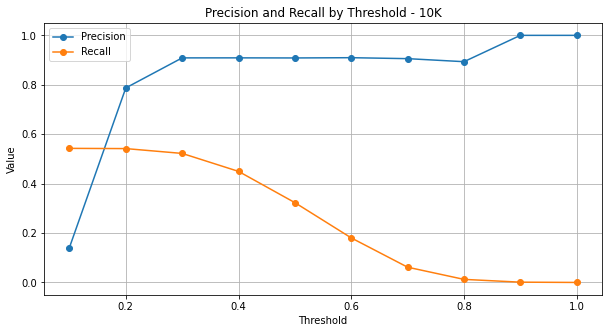

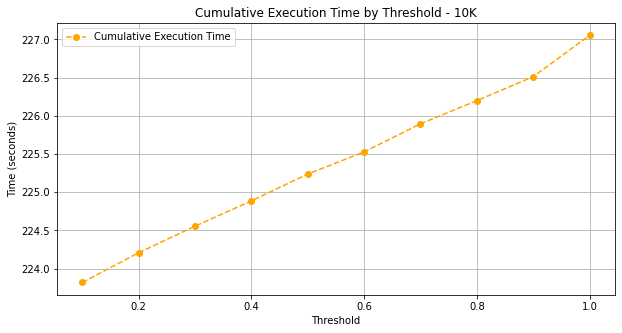

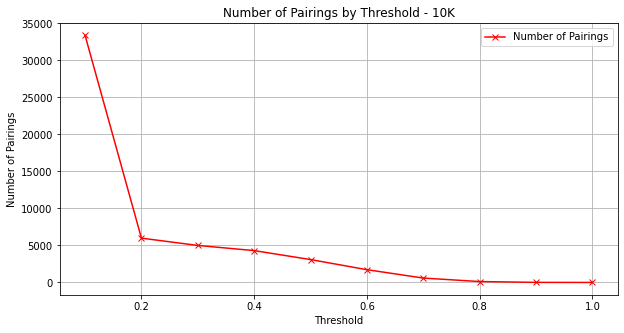

In [0]:
import matplotlib.pyplot as plt

# Function to calculate precision and recall
def calculate_precision_recall(filtered_pairs, ground_truth):
    true_positives = filtered_pairs.intersection(ground_truth)
    precision = len(true_positives) / len(filtered_pairs) if filtered_pairs else 0
    recall = len(true_positives) / len(ground_truth) if ground_truth else 0
    return precision, recall

# Convert the ground truth to a set for faster operations
ground_truth_set = set(ground_truth_rdd.collect())

# Initialize the cumulative execution time variable
cumulative_execution_time = time_of_preprocessing + time_of_prefix_filtering + time_of_lenght_filtering + time_of_position_filtering + time_of_deduplication + time_of_final_op

# Initialize lists for plotting
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
precisions = []
recalls = []
cumulative_execution_times = []
num_pairings = []  # List to store the number of pairings for each threshold

# Calculate metrics for each threshold
for threshold in sorted(thresholds):
    start_time = time.time()

    # Filter the Jaccard RDD by the current threshold
    filtered_jaccard = jaccard_rdd.filter(lambda x: x[1] >= threshold).map(lambda x: x[0])

    # Collect the filtered pairs into a set
    filtered_pairs_set = set(filtered_jaccard.collect())

    # Store the number of pairings
    num_pairings.append(len(filtered_pairs_set))

    # Print the number of pairings at specified thresholds
    if threshold in [0.7, 0.8, 0.9, 1.0]:
        print(f"Number of pairings at threshold {threshold}: {len(filtered_pairs_set)}")

    # Calculate precision and recall
    precision, recall = calculate_precision_recall(filtered_pairs_set, ground_truth_set)
    precisions.append(precision)
    recalls.append(recall)

    # Update the cumulative execution time
    cumulative_execution_time += (time.time() - start_time)
    cumulative_execution_times.append(cumulative_execution_time)

# Plotting Precision and Recall
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.title('Precision and Recall by Threshold - 10K')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Cumulative Execution Time
plt.figure(figsize=(10, 5))
plt.plot(thresholds, cumulative_execution_times, label='Cumulative Execution Time', marker='o', linestyle='--', color='orange')
plt.title('Cumulative Execution Time by Threshold - 10K')
plt.xlabel('Threshold')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the Number of Pairings
plt.figure(figsize=(10, 5))
plt.plot(thresholds, num_pairings, label='Number of Pairings', marker='x', color='red')
plt.title('Number of Pairings by Threshold - 10K')
plt.xlabel('Threshold')
plt.ylabel('Number of Pairings')
plt.legend()
plt.grid(True)
plt.show()

